# Supervised Land-Cover Classification with Random Forest
## Almere, The Netherlands: Pixel-wise Classification from Multi-band Raster Features

## 1. Objective

Train a supervised Random Forest model to classify land cover at pixel level using multi-band raster features and derived indices (NDVI, NDWI), then reconstruct predictions into a georeferenced output raster.

## 2. Environment Setup
### 2.1 Library Imports

In [31]:
import rioxarray as rxr
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

## 3. Data Ingestion and Visual Inspection

### Data Metadata

#### Feature Data (Sentinel-2)
- **Source**: Sentinel-2 Level-2A (MSI) — tile 31UFU
- **Product**: S2C_MSIL2A_20250819T104041_N0511_R008_T31UFU_20250819T155312.SAFE
- **Acquisition date**: 2025-08-19 (cloud cover ~5.6%)
- **Processing**: RGB multiband raster created by clipping the AOI from the original Sentinel-2 scene
- **CRS**: EPSG:4326 (WGS84) for the clipped raster used in this notebook

#### Label Data (ESA WorldCover)
- **Source**: ESA WorldCover Map v2 (2021)
- **Processing**: clipped to the same AOI and reprojected/resampled to match the feature grid
- **CRS**: EPSG:4326
- **Reclassified into**: Built-up / Vegetation / Water

### 3.1 Load Multi-band Imagery and Select Spectral Bands

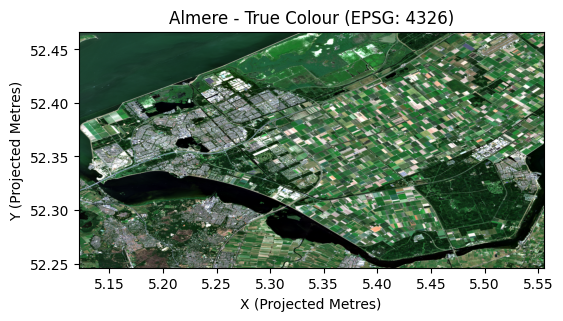

In [32]:
# Loading the Almere raster
data = rxr.open_rasterio('../data/almere_4326.tif')

# Selecting individual bands
red = data.sel(band=3).drop_vars('band')
green = data.sel(band=2).drop_vars('band')
blue = data.sel(band=1).drop_vars('band')
nir = data.sel(band=4).drop_vars('band')

# Creating an RGB array
rgb = xr.concat([red, green, blue], dim='band').transpose('y', 'x', 'band')

# Normalising the array values
rgb_p2 = rgb.quantile(0.02, dim=('y', 'x'))
rgb_p98 = rgb.quantile(0.98, dim=('y', 'x'))
rgb_stretched = (rgb - rgb_p2) / (rgb_p98 - rgb_p2)
rgb_stretched = rgb_stretched.clip(0, 1)

# Deriving geographic extent
bounds = data.rio.bounds()
extent = [bounds[0], bounds[2], bounds[1], bounds[3]]

# Plotting a true colour image
plt.figure(figsize=(6,6))
plt.imshow(rgb_stretched.values, extent=extent)
plt.title('Almere - True Colour (EPSG: 4326)')
plt.xlabel('X (Projected Metres)')
plt.ylabel('Y (Projected Metres)')
plt.show()

### 3.2 Load Label Raster and Define Class Schema

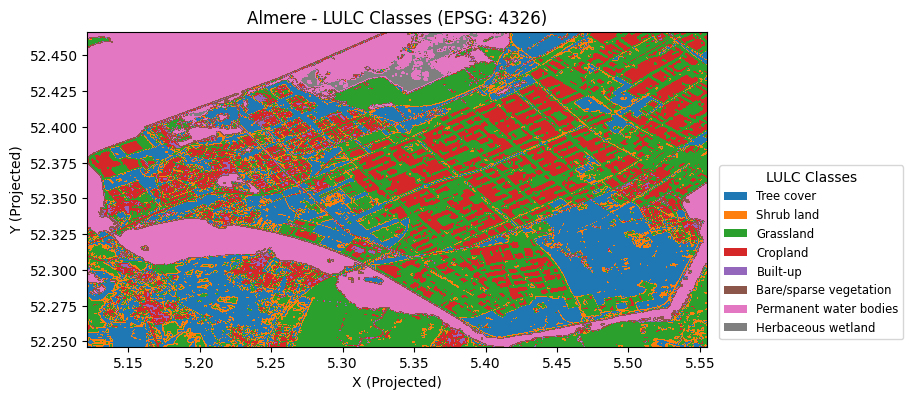

In [33]:
# Loading the LULC raster
data_2 = rxr.open_rasterio('../data/almere_4326.tif')
lulc = data_2.sel(band=1)

# Defining class labels
class_labels = {
    10: 'Tree cover',
    20: 'Shrub land',
    30: 'Grassland',
    40: 'Cropland',
    50: 'Built-up',
    60: 'Bare/sparse vegetation',
    80: 'Permanent water bodies',
    90: 'Herbaceous wetland'
}
# Class names source: https://collections.sentinel-hub.com/worldcover/readme.html

classes = list(class_labels.keys())
cmap_base = plt.get_cmap('tab10')
colours = [cmap_base(i) for i in range(len(classes))]

# Creating cmap and legend boundaries
cmap = mcolors.ListedColormap(colours)
norm = mcolors.BoundaryNorm(boundaries=classes + [max(classes) + 1], ncolors=len(classes))

# Getting raster bounds
bounds_2 = data_2.rio.bounds()
extent_2 = [bounds_2[0], bounds_2[2], bounds_2[1], bounds_2[3]]

# Plotting the raster
plt.figure(figsize=(8,6))
plt.imshow(lulc.values, extent=extent_2, norm=norm, cmap=cmap)
plt.title('Almere - LULC Classes (EPSG: 4326)')
plt.xlabel('X (Projected)')
plt.ylabel('Y (Projected)')

# Creating the legend
legend_handles = [
    Patch(facecolor=colours[i], label=class_labels[cls])
    for i, cls in enumerate(classes)
]
plt.legend(handles=legend_handles, loc='center left', title='LULC Classes', fontsize='small', bbox_to_anchor=(1.01, 0.3))
plt.show()

## 4. Spatial Alignment
### 4.1 Reproject/Resample Labels to Match Feature Grid

In [34]:
# Aligning the Almere and LULC rasters
aligned_labels = data_2.rio.reproject_match(data)

# Printing the raster shapes
print(data.shape)
print(aligned_labels.shape)

(4, 1826, 3595)
(1, 1826, 3595)


## 5. Feature Engineering
### 5.1 Compute Spectral Indices (NDVI, NDWI)

In [35]:
# Calculating and clipping NDVI
ndvi = (nir - red) / (nir + red)
ndvi = ndvi.clip(min=-1, max=1)

# Calculating and clipping NDWI
ndwi = (green - nir) / (green + nir)
ndwi = ndwi.clip(min=-1, max=1)

### 5.2 Assemble Feature Stack (Bands + Indices)

In [36]:
# Creating an xarray dataset with bands and indices
ds = xr.Dataset({
    'blue': blue,
    'green': green,
    'red': red,
    'nir': nir,
    'ndvi': ndvi,
    'ndwi': ndwi
})

## 6. Label Processing
### 6.1 Reclassify Original Labels into Target Classes

In [37]:
# Simplifying the WorlCover classes
reclass_map = {
    50: 0, # built-up
    10: 1, 20: 1, 30: 1, 40: 1, 60: 1, # vegetation
    80: 2 # water
}

# Reclassifying the LULC labels
reclassified = aligned_labels.copy()
for original, new in reclass_map.items():
    reclassified = xr.where(aligned_labels == original, new, reclassified)

# Masking out classes not included in the mapping    
valid_classes = list(reclass_map.keys())
mask = np.isin(aligned_labels, valid_classes)
reclassified = reclassified.where(mask)

## 7. Dataset Construction
### 7.1 Flatten Raster Features into (N × d) Design Matrix

In [38]:
# Stacking the dataset into a 3d array
features = ds.to_array(dim='feature')
features = features.transpose('y', 'x', 'feature')
n_rows, n_cols, n_features = features.shape

# Flattening the features and labels
flat_features = features.values.reshape(-1, n_features)
flat_labels = reclassified.values.flatten()

# Masking to remove NaNs
mask_2 = (~np.isnan(flat_labels)) & (~np.isnan(flat_features).any(axis=1))
x = flat_features[mask_2]
y = flat_labels[mask_2].astype(int)

## 8. Baseline Model
### 8.1 Stratified Train/Test Split and Initial Random Forest

In [39]:
# Splitting the data into training and testing tests
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42, 
    stratify=y
)

# Training a Random Forest classifier
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)

# Predicting labels
y_pred =rf.predict(x_test)

# Printing the confusion matrix
print('Confusion Matrix \n')
print(confusion_matrix(y_test, y_pred))

# Printing the classification report
print('\n Classification Report \n')
print(classification_report(y_test, y_pred, target_names=['Built-up', 'Vegetation', 'Water']))

Confusion Matrix 

[[ 81326  27180    779]
 [ 20382 870727   4832]
 [  1867  12731 253774]]

 Classification Report 

              precision    recall  f1-score   support

    Built-up       0.79      0.74      0.76    109285
  Vegetation       0.96      0.97      0.96    895941
       Water       0.98      0.95      0.96    268372

    accuracy                           0.95   1273598
   macro avg       0.91      0.89      0.90   1273598
weighted avg       0.95      0.95      0.95   1273598



### Interpretation of Baseline Model

The baseline Random Forest achieves 95% overall accuracy on the held-out test set, with strong performance across all classes. Vegetation and water are classified with high precision and recall (F1 ≈ 0.96), indicating strong separability in spectral feature space.

Built-up areas show lower recall (0.74), suggesting partial confusion with vegetation. This is consistent with spectral overlap between impervious surfaces and certain vegetated or mixed pixels. The macro-average F1 (0.90) confirms balanced performance across classes despite class imbalance.

### 8.2 Model Diagnostics: Confusion Matrix and Feature Importance

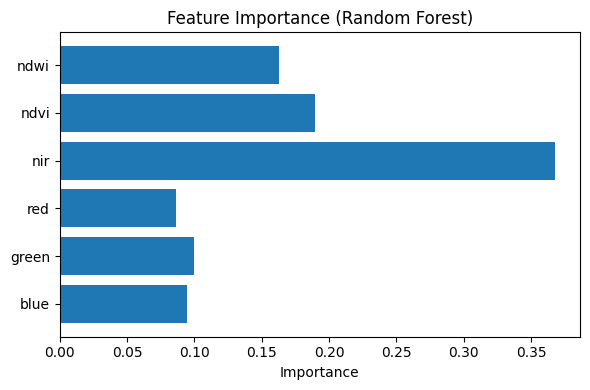

blue: 0.0941452863385911
green: 0.09942076876448863
red: 0.08616685883427007
nir: 0.3679103892932746
ndvi: 0.18975451346939687
ndwi: 0.16260218329997878


In [60]:
# Defining feature names
feature_names = ['blue', 'green', 'red', 'nir', 'ndvi', 'ndwi']

# Creating feature importance scores
importances = rf.feature_importances_

# Plotting the feature importance chart
plt.figure(figsize=(6,4))
plt.barh(feature_names, importances)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

# Printing feature importance scores in text form
for i,v in enumerate(feature_names):
    print(f'{v}: {importances[i]}')

### Feature Importance Analysis

NIR (0.37) is the dominant feature, followed by NDVI (0.19) and NDWI (0.16), confirming that near-infrared reflectance and vegetation/water indices drive most of the class discrimination.

The RGB bands contribute comparatively less (≈0.09–0.10 each), but still provide complementary spectral information. This distribution indicates that physically meaningful indices significantly enhance separability beyond raw visible bands.

## 9. Model Selection and Sensitivity Analysis
### 9.1 Ablation: Dropping Low-Value Features

In [45]:
# Dropping the RGB bands
x_selected = x[:, 3:]

# Splitting the data into training and testing tests
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x_selected, y, test_size=0.2, random_state=42, stratify=y
)

# Training a Random Forest classifier
rf_1 = RandomForestClassifier(
    n_estimators=50, max_depth=None, class_weight=None, random_state=42, n_jobs=-1
)
rf_1.fit(x_train_1, y_train_1)

# Predicting labels
y_pred_1 = rf_1.predict(x_test_1)

# Printing the classification report
print(classification_report(y_test_1, y_pred_1, target_names=['Built-up', 'Vegetation', 'Water']))

              precision    recall  f1-score   support

    Built-up       0.64      0.57      0.60    109285
  Vegetation       0.93      0.95      0.94    895941
       Water       0.96      0.90      0.93    268372

    accuracy                           0.91   1273598
   macro avg       0.84      0.81      0.82   1273598
weighted avg       0.91      0.91      0.91   1273598



### Ablation Study: Removing RGB Bands

Dropping the RGB bands reduces overall accuracy from 95% to 91% and significantly lowers Built-up F1-score (0.76 → 0.60). This indicates that visible-spectrum information remains important for distinguishing built-up areas from vegetation.

Although NIR and derived indices capture vegetation structure effectively, RGB bands provide complementary reflectance patterns critical for urban class discrimination.

### 9.2 Hyperparameter Sweep: Number of Trees (n_estimators)

In [47]:
for n in [25, 50, 75, 100]:
    print(f"\nTesting n_estimators={n}")
    rf_n = RandomForestClassifier(n_estimators=n, max_depth=None, class_weight=None, random_state=42, n_jobs=-1)
    rf_n.fit(x_train, y_train)
    y_pred_n = rf_n.predict(x_test)
    print(classification_report(y_test, y_pred_n, target_names=['Built-up', 'Vegetation', 'Water']))



Testing n_estimators=25
              precision    recall  f1-score   support

    Built-up       0.78      0.74      0.76    109285
  Vegetation       0.96      0.97      0.96    895941
       Water       0.98      0.95      0.96    268372

    accuracy                           0.95   1273598
   macro avg       0.91      0.89      0.90   1273598
weighted avg       0.95      0.95      0.95   1273598


Testing n_estimators=50
              precision    recall  f1-score   support

    Built-up       0.79      0.74      0.76    109285
  Vegetation       0.96      0.97      0.96    895941
       Water       0.98      0.95      0.96    268372

    accuracy                           0.95   1273598
   macro avg       0.91      0.89      0.90   1273598
weighted avg       0.95      0.95      0.95   1273598


Testing n_estimators=75
              precision    recall  f1-score   support

    Built-up       0.79      0.74      0.76    109285
  Vegetation       0.96      0.97      0.96    895941


### 9.3 Hyperparameter Sweep: Tree Depth (max_depth)

In [50]:
for d in [None, 25, 50, 75]:
    print(f"\nTesting max_depth={d}")
    rf_d = RandomForestClassifier(n_estimators=100, max_depth=d, class_weight=None, random_state=42, n_jobs=-1)
    rf_d.fit(x_train, y_train)
    y_pred_d = rf_d.predict(x_test)
    print(classification_report(y_test, y_pred_d, target_names=['Built-up', 'Vegetation', 'Water']))



Testing max_depth=None
              precision    recall  f1-score   support

    Built-up       0.79      0.74      0.77    109285
  Vegetation       0.96      0.97      0.96    895941
       Water       0.98      0.95      0.96    268372

    accuracy                           0.95   1273598
   macro avg       0.91      0.89      0.90   1273598
weighted avg       0.95      0.95      0.95   1273598


Testing max_depth=25
              precision    recall  f1-score   support

    Built-up       0.78      0.72      0.75    109285
  Vegetation       0.95      0.97      0.96    895941
       Water       0.98      0.94      0.96    268372

    accuracy                           0.94   1273598
   macro avg       0.90      0.88      0.89   1273598
weighted avg       0.94      0.94      0.94   1273598


Testing max_depth=50
              precision    recall  f1-score   support

    Built-up       0.79      0.74      0.77    109285
  Vegetation       0.96      0.97      0.96    895941
       

### 9.4 Class Imbalance Handling (class_weight)

In [51]:
for cw in [None, 'balanced']:
    print(f"\nTesting class_weight={cw}")
    rf_cw = RandomForestClassifier(n_estimators=100, max_depth=None, class_weight=cw, random_state=42, n_jobs=-1)
    rf_cw.fit(x_train, y_train)
    y_pred_cw = rf_cw.predict(x_test)
    print(classification_report(y_test, y_pred_cw, target_names=['Built-up', 'Vegetation', 'Water']))



Testing class_weight=None
              precision    recall  f1-score   support

    Built-up       0.79      0.74      0.77    109285
  Vegetation       0.96      0.97      0.96    895941
       Water       0.98      0.95      0.96    268372

    accuracy                           0.95   1273598
   macro avg       0.91      0.89      0.90   1273598
weighted avg       0.95      0.95      0.95   1273598


Testing class_weight=balanced
              precision    recall  f1-score   support

    Built-up       0.80      0.73      0.76    109285
  Vegetation       0.96      0.97      0.96    895941
       Water       0.98      0.95      0.96    268372

    accuracy                           0.95   1273598
   macro avg       0.91      0.88      0.90   1273598
weighted avg       0.95      0.95      0.95   1273598



### Hyperparameter Sensitivity Analysis

Increasing the number of trees beyond 50 yields negligible performance gains, indicating early convergence of ensemble stability. Similarly, limiting tree depth to 25 slightly reduces accuracy (94%), while deeper trees (≥50) maintain optimal performance.

Applying class weighting does not substantially improve minority-class recall, suggesting that spectral separability rather than imbalance is the primary performance constraint.

Overall, the model demonstrates robustness to moderate hyperparameter variation.

**Selected configuration:** 
* n_estimators=100
* max_depth=None
* class_weight=None (stable performance with minimal additional complexity).

## 10. Final Model Training and Inference
### 10.1 Train Final Random Forest and Evaluate on Held-out Test Set

In [52]:
# Training a Random Forest classifier
final_rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        class_weight=None,
        random_state=42,
        n_jobs=-1
)
final_rf.fit(x_train, y_train)

# Predicting labels for the test set
test_predictions = final_rf.predict(x_test)

# Printing the classification report
print('Classification report for the test set \n')
print(classification_report(y_test, test_predictions, target_names=['Built-up', 'Vegetation', 'Water']))

Classification report for the test set 

              precision    recall  f1-score   support

    Built-up       0.79      0.74      0.77    109285
  Vegetation       0.96      0.97      0.96    895941
       Water       0.98      0.95      0.96    268372

    accuracy                           0.95   1273598
   macro avg       0.91      0.89      0.90   1273598
weighted avg       0.95      0.95      0.95   1273598



### 10.2 Full-Scene Inference and Raster Reconstruction

In [53]:
# Predicting labels for the whole image
full_predictions = final_rf.predict(x)

# Creating an empty array
predicted_raster = np.full(flat_labels.shape, np.nan)

# Adding only valid pixels to the array
predicted_raster[mask_2] = full_predictions

# Reshaping the flat raster
predicted_raster_2d = predicted_raster.reshape(n_rows, n_cols)

# Printing the classification report
print('Classification report for the full image \n')
print(classification_report(y, full_predictions, target_names=['Built-up', 'Vegetation', 'Water']))

Classification report for the full image 

              precision    recall  f1-score   support

    Built-up       0.95      0.93      0.94    546427
  Vegetation       0.99      0.99      0.99   4479702
       Water       1.00      0.99      0.99   1341858

    accuracy                           0.99   6367987
   macro avg       0.98      0.97      0.98   6367987
weighted avg       0.99      0.99      0.99   6367987



### Final Model Performance and Generalisation

The final model maintains 95% test-set accuracy and achieves 99% accuracy on full-scene inference. The improved full-image metrics reflect the model’s ability to generalise across the spatial domain without overfitting to the test subset.

Built-up recall improves substantially at full-scene scale (0.93), suggesting stable decision boundaries once trained on the complete feature distribution.

These results confirm that the selected hyperparameters balance model capacity and generalisation effectively.

## 11. Output Generation
### 11.1 Visualise Predicted Land-Cover Map

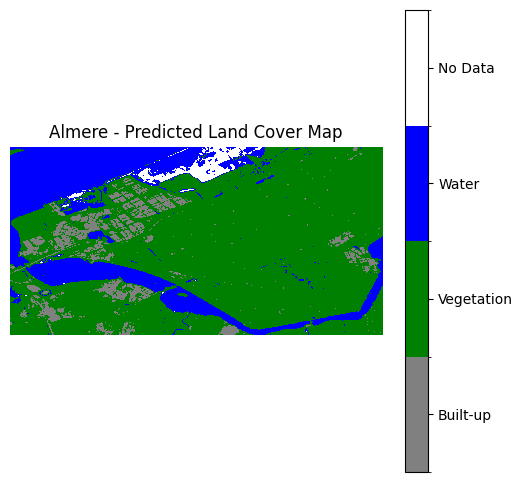

In [58]:
# Defining the colour map and normalisation
cmap_3 = mcolors.ListedColormap(["gray", "green", "blue", "white"])  # Last is for NaN
bounds_3 = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm_3 = mcolors.BoundaryNorm(bounds_3, cmap_3.N)

# Replacing NaNs with 3
masked_raster = np.copy(predicted_raster_2d)
masked_raster[np.isnan(masked_raster)] = 3

# Plotting the LULC map
plt.figure(figsize=(6,6))
plt.imshow(masked_raster, cmap=cmap_3, norm=norm_3)
plt.colorbar(
    ticks=[0, 1, 2, 3],
    format=plt.FuncFormatter(lambda val, _: ["Built-up", "Vegetation", "Water", "No Data"][int(val)])
)
plt.title("Almere - Predicted Land Cover Map")
plt.axis("off")
plt.show()

### 11.2 Export Georeferenced Prediction Raster (GeoTIFF)

In [59]:
# Converting the predicting raster to a DataArray
classified_da = xr.DataArray(
    predicted_raster_2d,
    coords={
        'y': data.y,
        'x': data.x
    },
    dims=('y', 'x'),
    name='lulc'
)

# Setting the CRS and dimensions
classified_da.rio.write_crs(data.rio.crs, inplace=True)
classified_da.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)

# Exporting the classified raster
classified_da.rio.to_raster('../data/predicted_lulc.tif', compress='LZW')

## 12. Summary

- Features: spectral bands + NDVI/NDWI  
- Labels: reclassified into Built-up / Vegetation / Water  
- Model: Random Forest with stratified split, diagnostics, and parameter sweeps  
- Output: pixel-wise prediction raster exported as compressed GeoTIFF